In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

df = pd.read_csv("../processed-datasets/feature-dataset.csv", sep="$")

df.head()

,class,url,status_code,meta_info,length,nb_hyphen,nb_cdn,nb_digits,nb_adword,nb_subdomains
0,0,https://crowdyfan.com/,200,Crowdyfan Sports News Nutrition More,22,0,0,0,0,0
1,0,https://dreamaways.com/,403,403 Forbidden,23,0,0,0,0,0
2,0,https://www.worldtravelserver.com/,200,London travel agencies United Kingdom weather ...,34,0,0,0,0,1
3,0,https://www.baarty.com/,200,Soluciones Para Bares Baartycom,23,0,0,0,0,1
4,0,https://ladamotors63.ru/,200,Lada Motors,24,0,0,2,1,0


In [2]:
df.shape

(74198, 10)

In [3]:
def mean_score(scoring):
    return {i:j.mean() for i,j in scoring.items()}

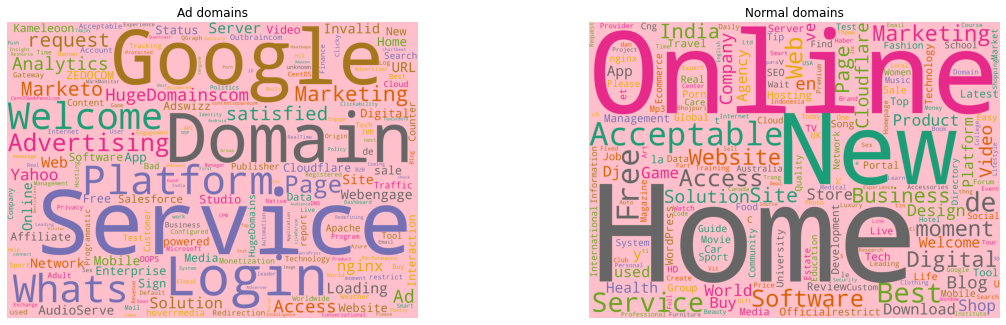

In [4]:
from wordcloud import WordCloud,STOPWORDS

STOPWORDS.update(["Unavailable", "Error", "Forbidden", "Temporarily", "None", "Found", "Denied", "Dead", "End"])

plt.figure(figsize=(40,25))
subset = df[df['class']==1]
text = subset.meta_info.values
cloud1=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,1)
plt.axis('off')
plt.title("Ad domains",fontsize=12)
plt.imshow(cloud1)
subset = df[df['class']==0]
text = subset.meta_info.values
cloud2=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,2)
plt.axis('off')
plt.title("Normal domains",fontsize=12)
plt.imshow(cloud2)

In [5]:
from nltk.stem.porter import PorterStemmer

porter=PorterStemmer()
def tokenizer(text):
        return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


X = df[['meta_info', 'status_code', 'length', 'nb_hyphen','nb_cdn', 'nb_digits', 'nb_adword', 'nb_subdomains']]

y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

tfidf = TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)

column_transformer = ColumnTransformer([('tfidf', tfidf, 'meta_info')])

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.pipeline import make_pipeline

def run_model(classifier):
    
    pipe = Pipeline([
        ('tfidf', column_transformer),
        ('classify', classifier)
    ])

    pipe.fit(X_train,y_train)
    
    scores = cross_validate(pipe, X, y, cv=10, scoring=["accuracy", "recall", "precision", "f1"])
    
    return (mean_score(scores))


## SVM

In [ ]:
from sklearn.svm import SVC

kernels = ["poly", "rbf", "linear", "sigmoid"]

result = []

for kernel in kernels:
    
    score = run_model(SVC(kernel=kernel))
    
    result.append(score)
    
    print (kernel, score)

In [ ]:
result

## SVM

In [11]:

import time
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

kernels = ["poly", "rbf", "linear", "sigmoid"]

for kernel in kernels:
    
    start = time.time()
    
    pipe = Pipeline([
        ('tfidf', column_transformer),
        ('classify', SVC(kernel=kernel))
    ])

    pipe.fit(X_train,y_train)
    
    end = time.time()
    
    print (kernel, pipe.score(X_test, y_test), " Time taken:", end-start)

poly 0.8988401535571346  Time taken: 189.81007981300354
rbf 0.8982275586049171  Time taken: 111.66968631744385
linear 0.8925916850445152  Time taken: 64.01131677627563
sigmoid 0.8784611614800294  Time taken: 56.460676431655884


## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(cv=6,scoring='accuracy',random_state=0,n_jobs=-1)

pipe = Pipeline([
    ('tfidf', column_transformer),
    ('classify', lr)
])
    
pipe.fit(X_train,y_train)
    
print ("Logistic Regression Accuracy: ", pipe.score(X_test, y_test))

/home/yk/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yk/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Logistic Regression Accuracy:  0.8964306134117455


## Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression(n_jobs=-1)

pipe = Pipeline([
    ('tfidf', column_transformer),
    ('classify', linearRegression)
])
    
pipe.fit(X_train,y_train)
    
print ("Linear Regression Accuracy: ", pipe.score(X_test, y_test))

Linear Regression Accuracy:  0.3536553001087811


## KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
import time

neighbors = [3, 5, 7, 9, 11, 15, 17, 19, 21, 23, 25]
accuracies = []

for n in neighbors:
    
    start = time.time()
    
    pipe = Pipeline([
        ('tfidf', column_transformer),
        ('classify', KNeighborsClassifier(n_neighbors=n, n_jobs=-1))
    ])
    
    pipe.fit(X_train,y_train)
    
    accuracy = pipe.score(X_test, y_test)
    accuracies.append(accuracy)
    end = time.time()
    print ("KNN with", n, "neighbor accuracy: ", accuracy, " Time taken:", end - start, "s")

KNN with 3 neighbor accuracy:  0.8871600098015192  Time taken: 30.96764826774597 s
KNN with 5 neighbor accuracy:  0.8827084864820713  Time taken: 29.65027689933777 s
KNN with 7 neighbor accuracy:  0.8834436004247325  Time taken: 29.581072330474854 s
KNN with 9 neighbor accuracy:  0.8837294780691007  Time taken: 29.973690509796143 s
KNN with 11 neighbor accuracy:  0.8798088703749081  Time taken: 29.673523664474487 s
KNN with 15 neighbor accuracy:  0.8808298619619375  Time taken: 30.055011987686157 s
KNN with 17 neighbor accuracy:  0.8804214653271257  Time taken: 33.53822064399719 s
KNN with 19 neighbor accuracy:  0.8795229927305399  Time taken: 31.287659645080566 s
KNN with 21 neighbor accuracy:  0.8782978028261047  Time taken: 36.31215786933899 s
KNN with 23 neighbor accuracy:  0.8776035285469248  Time taken: 35.29143309593201 s
KNN with 25 neighbor accuracy:  0.8767867352773013  Time taken: 34.329517126083374 s


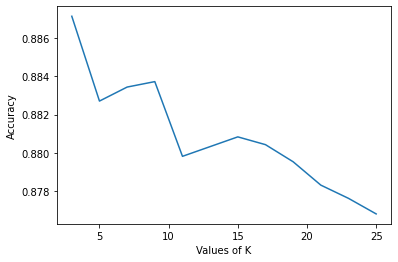

In [21]:
import matplotlib.pyplot as plt

plt.plot(neighbors, accuracies)
plt.xlabel("Values of K")
plt.ylabel("Accuracy")
plt.show()


## Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
import time

start = time.time()
    
pipe = Pipeline([
    ('tfidf', column_transformer),
    ('classify', RandomForestClassifier(n_jobs=-1))
])
    
pipe.fit(X_train,y_train)
    
accuracy = pipe.score(X_test, y_test)

end = time.time()

print ("RandomForestClassifier accuracy: ", accuracy, " Time taken:", end - start, "s")

RandomForestClassifier accuracy:  0.8968390100465572  Time taken: 9.012411832809448 s


In [12]:
pipeline = Pipeline([( "tfidf" , column_transformer),
                       ("classifier",LogisticRegression())])
# import Grid Search class
from sklearn.model_selection import GridSearchCV
# make lists of different parameters to check
parameters = {
  'n_estimators':[1,10,100,1000],
  'min_samples_split': [2,3,4,5]
  }
# initialize
grid_pipeline = GridSearchCV(pipeline,parameters)
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

ValueError: Invalid parameter 'min_samples_split' for estimator Pipeline(steps=[('tfidf',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<function tokenizer_porter at 0x7f5fdbf5bb50>),
                                                  'meta_info')])),
                ('classifier', LogisticRegression())]). Valid parameters are: ['memory', 'steps', 'verbose'].

## AdaBoost

In [7]:
from sklearn.ensemble import AdaBoostClassifier
import time

start = time.time()
    
pipe = Pipeline([
    ('tfidf', column_transformer),
    ('classify', AdaBoostClassifier())
])
    
pipe.fit(X_train,y_train)
    
accuracy = pipe.score(X_test, y_test)

end = time.time()

print ("AdaBoostClassifier accuracy: ", accuracy, " Time taken:", end - start, "s")

AdaBoostClassifier accuracy:  0.8738462795066568  Time taken: 4.002676486968994 s


## Decision Tree Classifier

In [8]:
from sklearn.tree import DecisionTreeClassifier

import time

start = time.time()
    
pipe = Pipeline([
    ('tfidf', column_transformer),
    ('classify', DecisionTreeClassifier())
])
    
pipe.fit(X_train,y_train)
    
accuracy = pipe.score(X_test, y_test)

end = time.time()

print ("DecisionTreeClassifier accuracy: ", accuracy, " Time taken:", end - start, "s")

DecisionTreeClassifier accuracy:  0.8887935963407662  Time taken: 14.064345359802246 s


[Text(0.625, 0.9166666666666666, 'X[19317] <= 0.5\ngini = 0.485\nsamples = 49712\nvalue = [29190, 20522]'),
 Text(0.5625, 0.75, 'X[10628] <= 0.298\ngini = 0.383\nsamples = 37849\nvalue = [28072, 9777]'),
 Text(0.3125, 0.5833333333333334, 'X[9113] <= 0.471\ngini = 0.351\nsamples = 36158\nvalue = [27937, 8221]'),
 Text(0.25, 0.4166666666666667, 'X[28577] <= 0.345\ngini = 0.332\nsamples = 35382\nvalue = [27937, 7445]'),
 Text(0.125, 0.25, 'X[10544] <= 0.482\ngini = 0.319\nsamples = 34852\nvalue = [27910, 6942]'),
 Text(0.0625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.375, 0.25, 'X[24516] <= 0.165\ngini = 0.097\nsamples = 530\nvalue = [27, 503]'),
 Text(0.3125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.4375, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.375, 0.4166666666666667, 'gini = 0.0\nsamples = 776\nvalue = [0, 776]'),
 Text(0.8125, 0.5833333333333334, 'X[10628] <= 0.669\ngini = 0.147\nsamples = 1691\nvalue = [135, 1556

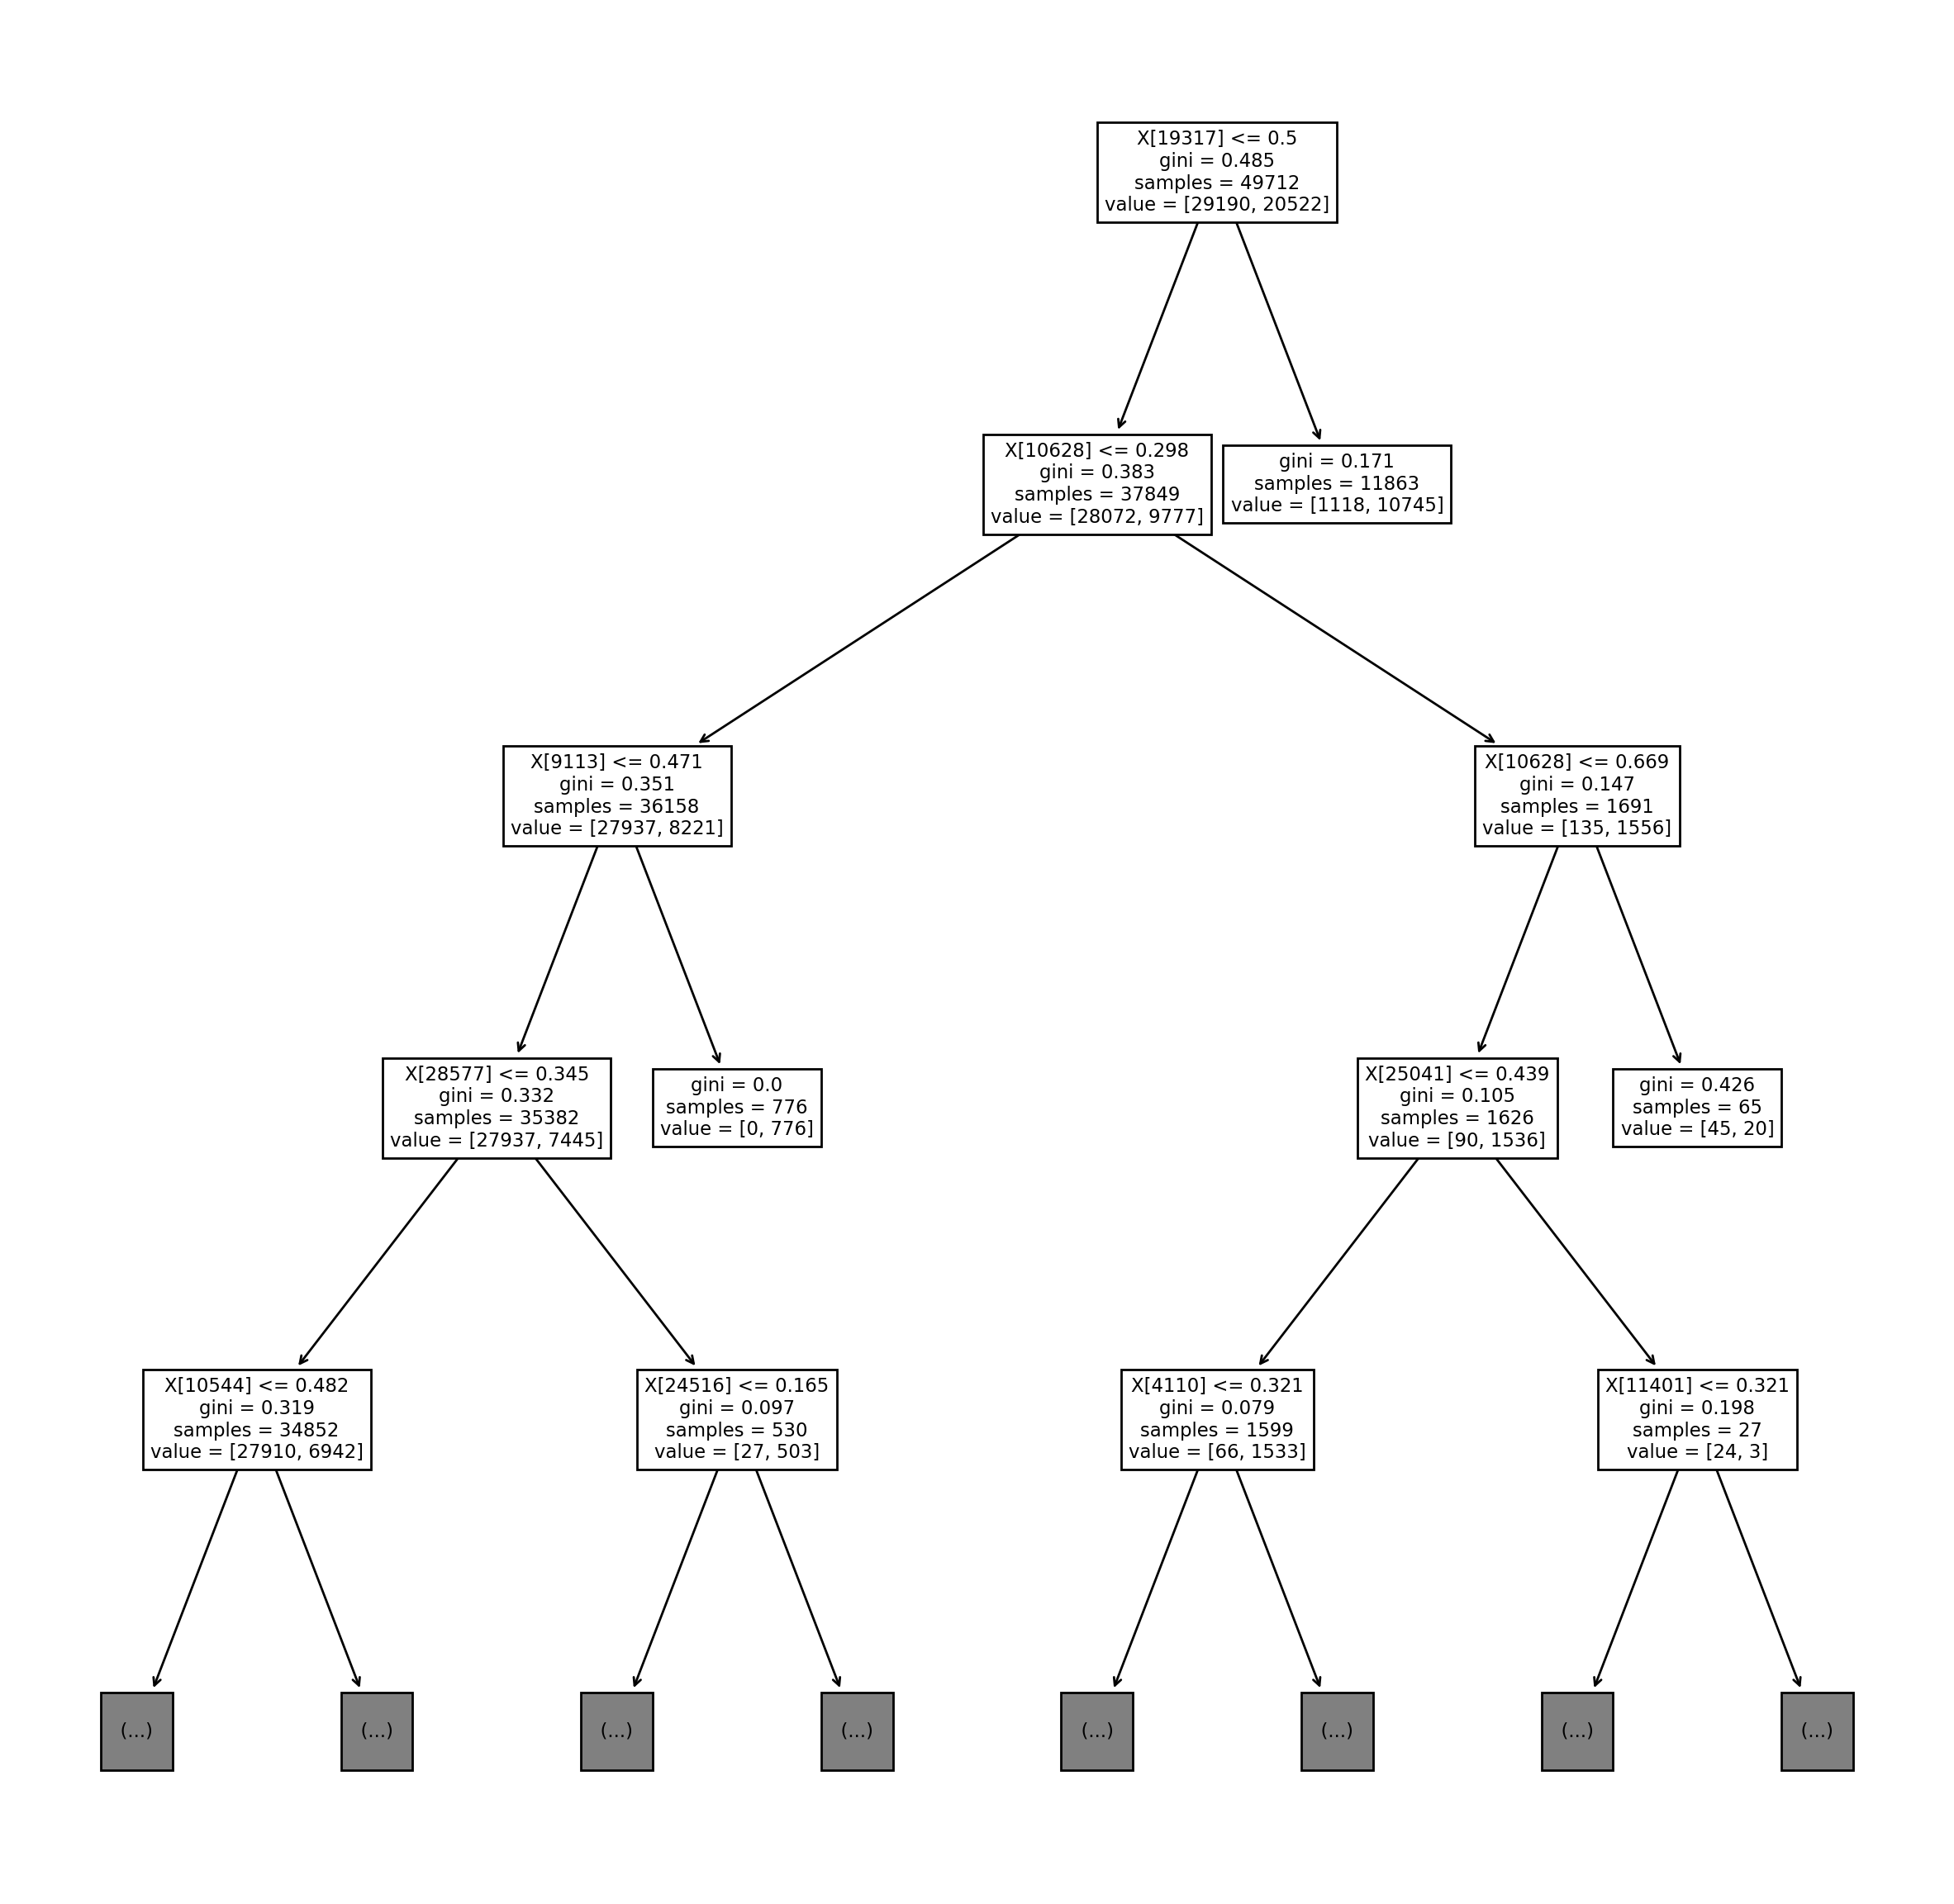

In [19]:
from sklearn.tree import plot_tree

plt.figure(1, figsize=(15, 15), dpi=200)

plot_tree(pipe['classify'], max_depth=4)


    

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn import metrics

def run_model(pipe):
    scores = cross_validate(pipe, X, y, cv=10, scoring=["accuracy", "recall", "precision", "f1"])
    print (mean_score(scores))
    

In [36]:
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores = cross_validate(pipe, X, y, cv=2, scoring=["accuracy", "recall", "precision", "f1"])

plt.show()

print (mean_score(scores))

{'fit_time': 8.450103282928467, 'score_time': 1.5142279863357544, 'test_accuracy': 0.8502924607132267, 'test_recall': 0.7730915635755601, 'test_precision': 0.8539052254278839, 'test_f1': 0.8066331743408603}


In [19]:
conf_mat

array([[38486,  5123],
       [ 4147, 26442]])